# Outcome oriented prediction with CNN

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.utils as torch_utils
import pandas as pd
from torch.utils.data import DataLoader,Dataset
from torchvision import transforms
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report


In [2]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"

os.environ["CUDA_VISIBLE_DEVICES"]="0"
!nvidia-smi

Wed Jul 29 16:57:20 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 396.51                 Driver Version: 396.51                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:02:00.0 Off |                  N/A |
| 26%   49C    P2    52W / 250W |   3083MiB / 11177MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:03:00.0 Off |                  N/A |
| 23%   34C    P8    16W / 250W |     12MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

## Construct custom dataloader

In [3]:
class Customdataset(Dataset):
    def __init__(self,x_data,y_data,transform=None):
        '''
        Call stored dataset
        
        Params
        second: Ellapsed second from the beginning of events 
        encoding_type: Encoding method for outcomeprediction ex) Static, last_state, aggregation, etc.
        '''
        
        
        
        # Transforms
        self.transform = transform
        self.y_data=y_data.to_numpy()
        self.x_data=x_data.to_numpy()
    def __len__(self):
        return len(self.x_data)
    
    def __getitem__(self,idx):
        
        # Convert x and y data to torch flaot tensor
        x = torch.FloatTensor(self.x_data[idx])
        y = self.y_data[idx]
        return x,y

In [4]:
encoding_type = 'last_state'
prefix = 5
input_data = pd.read_csv('../data/'+encoding_type+'_'+str(prefix)+'.csv')
y_data = input_data.loc[:,['Label']]
input_data = input_data.drop(['Label'],axis=1)
x_data = input_data
x_data = x_data.drop('(case) SUMleges',axis=1)

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.33, random_state=69)


In [5]:
trainset = Customdataset(x_train,y_train)
testset = Customdataset(x_test,y_test)

In [6]:
batch_size =1
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(testset,batch_size=1)

## Data description
X value  
BPIC 2015_2 train loader dataset size is 1 \* 816  
Each rows is a case and 1 cases for one train iteration due to batch_size is 1.  
816 elements are included in a single case which are timestamp related information, case and event attributes.  

Y value  
Size of y value is 1 and content is 0 or 1 binary class.

In [7]:
x = torch.ones([1,816])
x = x.unsqueeze(0)
print(x.shape)
sampling = nn.MaxPool1d(2, 2)
cnn1 = nn.Conv1d(in_channels=1, out_channels=4, kernel_size=3, stride=1)
y = cnn1(x)
y = sampling(y)
print(y.shape)
cnn2 = nn.Conv1d(in_channels=4, out_channels=2, kernel_size=3, stride=1)
y = cnn2(y)
y = sampling(y)
print(y.shape)
cnn3 = nn.Conv1d(in_channels=2, out_channels=1, kernel_size=3, stride=1)
y = cnn3(y)
y = sampling(y)
print(y.shape)
y = y.squeeze()
print(y.shape)
ll1 = nn.Linear(100,50)
ll2 = nn.Linear(50,25)
ll3 = nn.Linear(25,1)
y = ll1(y)
y = ll2(y)
y = ll3(y)
print(y.shape)

torch.Size([1, 1, 816])
torch.Size([1, 4, 407])
torch.Size([1, 2, 202])
torch.Size([1, 1, 100])
torch.Size([100])
torch.Size([1])


In [8]:
class CNN_prediction(nn.Module):
    def __init__(self):
        super(CNN_prediction,self).__init__()
        
        # CNN part       
        self.activation = nn.ReLU()
        self.subsampling = nn.MaxPool1d(2,2)

        self.cnn1 = nn.Conv1d(in_channels=1, out_channels=4, kernel_size=3, stride=1)
        self.cnn2 = nn.Conv1d(in_channels=4, out_channels=2, kernel_size=3, stride=1)
        self.cnn3 = nn.Conv1d(in_channels=2, out_channels=1, kernel_size=3, stride=1)
        
        self.classifier = nn.Sequential(
                                        nn.Dropout(),
                                        nn.Linear(100, 50),
                                        nn.ReLU(),
                                        nn.Dropout(),
                                        nn.Linear(50, 25),
                                        nn.ReLU(),
                                        nn.Linear(25, 1)
        )
        self.cnn_featuremap =0
    
    def forward(self, inputs):

        """
        implement code here
        """
        inputs = inputs.unsqueeze(0)
        hidden = self.cnn1(inputs)
        hidden = self.activation(hidden)
        hidden = self.subsampling(hidden)

        hidden = self.cnn2(hidden)
        hidden = self.activation(hidden)
        hidden = self.subsampling(hidden)

        hidden = self.cnn3(hidden)
        hidden = self.activation(hidden)
        hidden = self.subsampling(hidden)

        hidden = hidden.squeeze()
        self.cnn_featuremap = hidden
        
        outputs = self.classifier(hidden)
        
        return outputs

model = CNN_prediction().cuda()

# Loss function & Optimizers
"""
you can change the loss and optimizer
"""
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)



# Hyperparameters
"""
you can change the value
"""
num_epochs = 100
batch_size = 1   

In [9]:
def binary_acc(train_predict, train_y):
    train_predict_tag = torch.round(torch.sigmoid(train_predict))
    correct_results_sum = (train_predict_tag == train_y).sum().float()
    acc = correct_results_sum/train_y.shape[0]
    acc = torch.round(acc *100)
    
    return acc    

In [10]:
# Train CNN_prediction first

accuracy_graph = {'train':[], 'test':[], 'epoch': []}
loss_graph = {'train':[], 'test':[], 'epoch': []}
model = CNN_prediction().cuda()

for epoch in range(num_epochs):
    epoch_loss = 0
    epoch_acc = 0
    # Training
    for train_x, train_y in train_loader: 
        train_y = train_y.squeeze(1)
        train_x, train_y = train_x.cuda(), train_y.cuda()
        
        
        train_predict = model(train_x)
        train_predict = train_predict.float()
        train_y = train_y.float()
        
        loss = criterion(torch.sigmoid(train_predict), train_y)
        acc = binary_acc(train_predict, train_y)
        # Backpropagation        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
                

    # Evaluation
    if epoch % 10 ==0:
        
        test_acc = 0
        test_loss =0
        
        for test_x, test_y in test_loader:

            with torch.autograd.no_grad():
                test_y = test_y.squeeze(1)
                test_x, test_y = test_x.cuda(), test_y.cuda()
                test_predict = model(test_x)

            test_predict = test_predict.float()
            test_y = test_y.float()

            loss = criterion(torch.sigmoid(test_predict), test_y)
            acc = binary_acc(test_predict, test_y)
            
            test_loss += loss.item()
            test_acc += acc.item()
                               
        print("\ntrain accuracy: {:.2f} %, test accuracy: {:.2f} %".format(epoch_acc/len(train_loader), test_acc/len(test_loader)))
        print("epoch:{}, train_loss: {:.4f}, test_loss: {:.4f}".format(epoch+1, epoch_loss/len(train_loader), test_loss/len(test_loader))) 
        accuracy_graph['epoch'] = epoch+1
        accuracy_graph['train'] = epoch_acc/len(train_loader)

        loss_graph['epoch'] = epoch+1
        loss_graph['train'] = epoch_loss/len(train_loader)
        loss_graph['test'] = test_loss/len(test_loader)


#         torch.save(model.state_dict(), "./cnn_predic.pt")


train accuracy: 36.94 %, test accuracy: 32.85 %
epoch:1, train_loss: 6.3660, test_loss: 7.0498

train accuracy: 38.92 %, test accuracy: 35.40 %
epoch:11, train_loss: 6.1621, test_loss: 7.6122

train accuracy: 38.20 %, test accuracy: 36.86 %
epoch:21, train_loss: 6.5988, test_loss: 5.7409

train accuracy: 35.68 %, test accuracy: 33.58 %
epoch:31, train_loss: 6.8619, test_loss: 7.4777

train accuracy: 36.40 %, test accuracy: 36.86 %
epoch:41, train_loss: 6.8993, test_loss: 6.4273

train accuracy: 36.04 %, test accuracy: 33.94 %
epoch:51, train_loss: 6.6108, test_loss: 7.6310

train accuracy: 37.12 %, test accuracy: 35.77 %
epoch:61, train_loss: 6.6489, test_loss: 7.0289

train accuracy: 39.46 %, test accuracy: 37.96 %
epoch:71, train_loss: 6.4307, test_loss: 6.9374

train accuracy: 39.64 %, test accuracy: 33.94 %
epoch:81, train_loss: 6.3012, test_loss: 6.5047

train accuracy: 34.59 %, test accuracy: 35.77 %
epoch:91, train_loss: 6.8369, test_loss: 7.0265


In [11]:
test_acc = 0
test_loss =0
y_predict_list=[]
model.eval()

testset = Customdataset(x_test,y_test)
test_loader = DataLoader(testset,batch_size=1)

with torch.autograd.no_grad():
    for test_x, test_y in test_loader:
        test_y = test_y.squeeze(1)
        test_x, test_y = test_x.cuda(), test_y.cuda()
        test_predict = model(test_x)

        test_predict = test_predict.float()
        test_y = test_y.float()
        
        test_predict_tag = torch.round(torch.sigmoid(test_predict))
        y_predict_list.append(test_predict_tag.cpu().numpy())
        
print(classification_report(y_test,y_predict_list))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       224
         1.0       0.18      1.00      0.31        50

    accuracy                           0.18       274
   macro avg       0.09      0.50      0.15       274
weighted avg       0.03      0.18      0.06       274



/home/suhwan/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


555
274
100


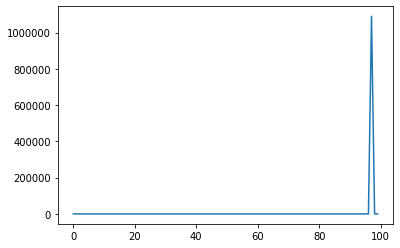

In [39]:
trainset = Customdataset(x_train,y_train)
train_loader = DataLoader(trainset,batch_size=1)

featured_train=[]
with torch.autograd.no_grad():
    for train_x, train_y in train_loader:
        train_y = train_y.squeeze(1)
        train_x, train_y = train_x.cuda(), train_y.cuda()
        train_predict = model(train_x)

        train_predict = train_predict.float()
        train_y = train_y.float()
        
        test_predict_tag = torch.round(torch.sigmoid(test_predict))
        y_predict_list.append(test_predict_tag.cpu().numpy())
        featured_train.append(model.cnn_featuremap.cpu().numpy())
print(len(featured_train))
plt.plot(featured_train[1])
testset = Customdataset(x_test,y_test)
test_loader = DataLoader(testset,batch_size=1)

featured_test=[]
with torch.autograd.no_grad():
    for test_x, test_y in test_loader:
        test_y = test_y.squeeze(1)
        test_x, test_y = test_x.cuda(), test_y.cuda()
        test_predict = model(test_x)

        test_predict = test_predict.float()
        test_y = test_y.float()
        
        test_predict_tag = torch.round(torch.sigmoid(test_predict))
        y_predict_list.append(test_predict_tag.cpu().numpy())
        featured_test.append(model.cnn_featuremap.cpu().numpy())
print(len(featured_test))
print(len(featured_test[0]))

In [31]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

In [35]:
ml = RandomForestClassifier(criterion='entropy',n_estimators=100)
ml.fit(featured_train,y_train)
y_pred = ml.predict(featured_test)

print(classification_report(y_test,y_pred))

/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97       224
         1.0       0.95      0.78      0.86        50

    accuracy                           0.95       274
   macro avg       0.95      0.89      0.91       274
weighted avg       0.95      0.95      0.95       274

